In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from models import GFNN
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

In [2]:
# import data from pickle file
data = pd.read_pickle("SimulatedWaves.pkl")
wave = np.array(data['Wave'])
wave = [np.array(x) for x in wave]
NumPh = np.array([len(x) for x in data['Times']])

In [3]:
# Separate train data and test data
wave_train = np.array(wave[:7500])
NumPh_train = np.array(NumPh[:7500])
wave_test = np.array(wave[7500:])
NumPh_test = np.array(NumPh[7500:])

### NN model try

In [4]:
# Parameters
layer_num, n_hidden, batch_size, learning_rate = 10, 50, 10, 0.1
n_input, n_out = 100, 1

In [5]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
    
train_data = Data(wave_train, NumPh_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = Data(wave_test, NumPh_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [6]:
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     break

In [7]:
model = GFNN(layer_num, n_input, n_hidden, n_out)
#print(model)

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
num_epochs = 50
loss_values = []


for epoch in tqdm(range(num_epochs)):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

100%|███████████████████████████████████████████| 50/50 [01:37<00:00,  1.96s/it]


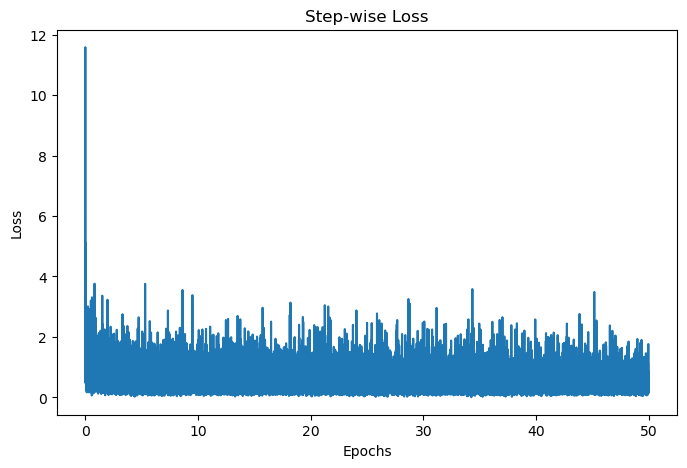

In [10]:
step = np.linspace(0, 50, 37500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.yscale('log')
plt.show()

In [11]:
y_pred, y_test,correct,total = [],[],0,0
with torch.no_grad():
    for X, y in train_dataloader:
        outputs = model(X)
        outputs = np.array(outputs)
        for i in range(len(outputs)):
            y_pred.append(int(round(outputs[i][0])))
            if(int(round(outputs[i][0]))==y[i]):
                correct+=1
            y_test.append(y[i])
        total += len(y)
print(f'Accuracy of the network on the 7500 train instances: {100 * correct // total}%')

Accuracy of the network on the 7500 train instances: 61%


In [12]:
y_pred, y_test,correct,total = [],[],0,0
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        outputs = np.array(outputs)
        for i in range(len(outputs)):
            y_pred.append(int(round(outputs[i][0])))
            if(int(round(outputs[i][0]))==y[i]):
                correct+=1
            y_test.append(y[i])
        total += len(y)
print(f'Accuracy of the network on the 2500 test instances: {100 * correct // total}%')

Accuracy of the network on the 2500 test instances: 60%


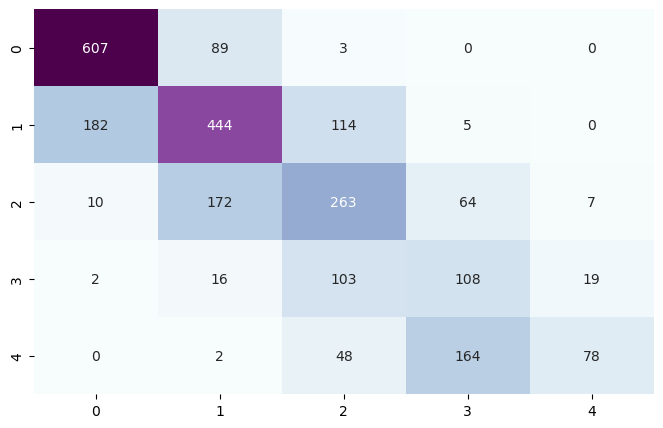

In [13]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g",cmap = 'BuPu')

plt.show()